In [1]:
import findspark
findspark.init()
findspark.find()

'/opt/spark'

In [2]:
from pyspark.sql import SparkSession

DIRECTORY = ".."
spark = SparkSession.builder.appName("Read CSV").getOrCreate()
df_ddos = spark.read.format("csv").option("header", "true").load(DIRECTORY + "/ddos-tcp-syn-flood.csv")
df_normal = spark.read.format("csv").option("header", "true").load(DIRECTORY + "/normal-traffic.csv")
df_scanning = spark.read.format("csv").option("header", "true").load(DIRECTORY + "/port-scanning.csv")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/02 08:37:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df_ddos.show()

24/06/02 08:37:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+---------------+--------------+------------------+----------+-----------+------------------+-------------+-----------+-----------------------+-----------+--------------+-------------------+----------------------+-------------------+------------+---------------------+--------------------+-------------+-------------+------------+------------+------------+------------------+------------------+------------------+---------------------+-----------+----------+-------------+-------+-----------+--------------------+-------+-----------+--------+----------+--------------+------------+----------------+----------+------------+------------------+----------------------+-------------------------+-----------------+----------------------+-------------+-------------+--------+-------------------+--------+------------+--------------+--------------+----------+--------------+--------+---------+--------------+-------------+------------+-----------+
|          frame.time|    ip.src_host| 

In [4]:
df_normal.show()

+--------------------+-------------+-------------+------------------+----------+-----------+------------------+-------------+-----------+-----------------------+-----------+--------------+-------------------+----------------------+-------------------+------------+---------------------+--------------------+-------------+-------------+-------+------------+------------+------------------+------------------+------------------+---------------------+-----------+----------+-------------+-------+--------------------+--------------------+-------+-----------+--------+----------+--------------+------------+----------------+----------+------------+------------------+----------------------+-------------------------+-----------------+----------------------+-------------+-------------+--------+-------------------+--------------------+------------+--------------+--------------+--------------------+--------------+--------+---------+--------------+-------------+------------+-----------+
|          frame

In [5]:
df_scanning.show()

+--------------------+-------------+-------------+------------------+----------+-----------+------------------+-------------+-----------+-----------------------+-----------+--------------+-------------------+----------------------+-------------------+------------+---------------------+--------------------+-------------+-------------+------------+------------+------------+------------------+------------------+------------------+---------------------+-----------+----------+-------------+-------+-----------+-----------+-------+-----------+--------+----------+--------------+------------+----------------+----------+------------+------------------+----------------------+-------------------------+-----------------+----------------------+-------------+-------------+--------+-------------------+--------+------------+--------------+--------------+----------+--------------+--------+---------+--------------+-------------+------------+-------------+
|          frame.time|  ip.src_host|  ip.dst_host

In [6]:
import re

def rename_columns(df):
    for col_name in df.columns:
        new_col_name = re.sub(r'\.', '-', col_name)
        df = df.withColumnRenamed(col_name, new_col_name)
    return df

In [7]:
df_ddos = rename_columns(df_ddos)
df_ddos.show()

+--------------------+---------------+--------------+------------------+----------+-----------+------------------+-------------+-----------+-----------------------+-----------+--------------+-------------------+----------------------+-------------------+------------+---------------------+--------------------+-------------+-------------+------------+------------+------------+------------------+------------------+------------------+---------------------+-----------+----------+-------------+-------+-----------+--------------------+-------+-----------+--------+----------+--------------+------------+----------------+----------+------------+------------------+----------------------+-------------------------+-----------------+----------------------+-------------+-------------+--------+-------------------+--------+------------+--------------+--------------+----------+--------------+--------+---------+--------------+-------------+------------+-----------+
|          frame-time|    ip-src_host| 

In [8]:
df_normal = rename_columns(df_normal)
df_normal.show()

+--------------------+-------------+-------------+------------------+----------+-----------+------------------+-------------+-----------+-----------------------+-----------+--------------+-------------------+----------------------+-------------------+------------+---------------------+--------------------+-------------+-------------+-------+------------+------------+------------------+------------------+------------------+---------------------+-----------+----------+-------------+-------+--------------------+--------------------+-------+-----------+--------+----------+--------------+------------+----------------+----------+------------+------------------+----------------------+-------------------------+-----------------+----------------------+-------------+-------------+--------+-------------------+--------------------+------------+--------------+--------------+--------------------+--------------+--------+---------+--------------+-------------+------------+-----------+
|          frame

In [9]:
df_scanning = rename_columns(df_scanning)
df_scanning.show()

+--------------------+-------------+-------------+------------------+----------+-----------+------------------+-------------+-----------+-----------------------+-----------+--------------+-------------------+----------------------+-------------------+------------+---------------------+--------------------+-------------+-------------+------------+------------+------------+------------------+------------------+------------------+---------------------+-----------+----------+-------------+-------+-----------+-----------+-------+-----------+--------+----------+--------------+------------+----------------+----------+------------+------------------+----------------------+-------------------------+-----------------+----------------------+-------------+-------------+--------+-------------------+--------+------------+--------------+--------------+----------+--------------+--------+---------+--------------+-------------+------------+-------------+
|          frame-time|  ip-src_host|  ip-dst_host

In [10]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import FloatType
from pyspark.sql.functions import lit

selected_columns = [
    "arp-opcode",
    "arp-hw-size",
    "icmp-checksum",
    "icmp-seq_le",
    "icmp-transmit_timestamp",
    "icmp-unused",
    "http-file_data",
    "http-content_length",
    "http-request-uri-query",
    "http-request-method",
    "http-referer",
    "http-request-full_uri",
    "http-request-version",
    "http-response",
    "http-tls_port",
    "tcp-ack",
    "tcp-ack_raw",
    "tcp-connection-fin",
    "tcp-connection-rst",
    "tcp-connection-syn",
    "tcp-connection-synack",
    "tcp-dstport",
    "tcp-flags_index",
    "tcp-flags-ack",
    "tcp-len",
    "tcp-seq",
    "tcp-srcport",
    "udp-port",
    "udp-stream",
    "udp-time_delta",
    "dns-qry-name",
    "dns-qry-name-len_index",
    "dns-qry-qu_index",
    "dns-qry-type",
    "dns-retransmission",
    "dns-retransmit_request",
    "dns-retransmit_request_in",
    "mqtt-conack-flags_index",
    "mqtt-conflag-cleansess",
    "mqtt-conflags_index",
    "mqtt-hdrflags_index",
    "mqtt-len",
    "mqtt-msg_decoded_as",
    "mqtt-msg_index",
    "mqtt-msgtype",
    "mqtt-proto_len",
    "mqtt-protoname_index",
    "mqtt-topic_index",
    "mqtt-topic_len",
    "mqtt-ver",
    "mbtcp-len",
    "mbtcp-trans_id",
    "mbtcp-unit_id",
    "Attack_type_index"
]



def data_conversion(selected_df, index):
    #indexer = StringIndexer(inputCol="Attack_type", outputCol="Attack_type_index")
    #indexed_df = indexer.fit(selected_df).transform(selected_df)

    #indexed_df.select("Attack_type", "Attack_type_index").distinct().show()
    indexed_df = selected_df.withColumn("Attack_type_index", lit(index))
    
    tcp_flags_indexer = StringIndexer(inputCol="tcp-flags", outputCol="tcp-flags_index")
    indexed_df = tcp_flags_indexer.fit(indexed_df).transform(indexed_df)

    dns_qry_name_len_indexer = StringIndexer(inputCol="dns-qry-name-len", outputCol="dns-qry-name-len_index")   
    indexed_df = dns_qry_name_len_indexer.fit(indexed_df).transform(indexed_df)
    dns_qry_qu_indexer = StringIndexer(inputCol="dns-qry-qu", outputCol="dns-qry-qu_index")
    indexed_df = dns_qry_qu_indexer.fit(indexed_df).transform(indexed_df)

    mqtt_conack_flags_indexer = StringIndexer(inputCol="mqtt-conack-flags", outputCol="mqtt-conack-flags_index")
    indexed_df = mqtt_conack_flags_indexer.fit(indexed_df).transform(indexed_df)
    mqtt_conflags = StringIndexer(inputCol="mqtt-conflags", outputCol="mqtt-conflags_index")
    indexed_df = mqtt_conflags.fit(indexed_df).transform(indexed_df)

    mqtt_hdrflags = StringIndexer(inputCol="mqtt-hdrflags", outputCol="mqtt-hdrflags_index")
    indexed_df = mqtt_hdrflags.fit(indexed_df).transform(indexed_df)
    mqtt_msg = StringIndexer(inputCol="mqtt-msg", outputCol="mqtt-msg_index")
    indexed_df = mqtt_msg.fit(indexed_df).transform(indexed_df)

    mqtt_protoname = StringIndexer(inputCol="mqtt-protoname", outputCol="mqtt-protoname_index")
    indexed_df = mqtt_protoname.fit(indexed_df).transform(indexed_df)

    mqtt_topic = StringIndexer(inputCol="mqtt-topic", outputCol="mqtt-topic_index")
    indexed_df = mqtt_topic.fit(indexed_df).transform(indexed_df)



    nw_df = indexed_df.select(selected_columns)
    return nw_df



In [11]:
df_ddos = data_conversion(df_ddos, 0)

In [12]:
df_normal = data_conversion(df_normal, 2)

In [13]:
df_scanning = data_conversion(df_scanning, 1)

In [14]:
from pyspark.sql.functions import col, countDistinct


def count_unique_values(df):
   
    min_unique_values = 10


    unique_value_counts = df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns))


    print("\nLiczba unikalnych wartości w poszczególnych kolumnach:")
    unique_value_counts.show()


    #columns_to_drop = []


    #for column in df.columns:
    #    unique_values = unique_value_counts.select(column).collect()[0][0]
    #    if unique_values < min_unique_values:
    #        columns_to_drop.append(column)


    #df_filtered = df.drop(*columns_to_drop)


    #print("\nStruktura danych po usunięciu kolumn:")
    #df_filtered.printSchema()

In [15]:
count_unique_values(df_ddos)


Liczba unikalnych wartości w poszczególnych kolumnach:


24/06/02 08:45:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 08:45:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 08:45:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 08:45:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 08:45:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 08:45:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 08:45:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 08:45:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/02 08:45:52 WARN RowBasedKeyValueBatch: Calling spill() on

+----------+-----------+-------------+-----------+-----------------------+-----------+--------------+-------------------+----------------------+-------------------+------------+---------------------+--------------------+-------------+-------------+-------+-----------+------------------+------------------+------------------+---------------------+-----------+---------------+-------------+-------+-------+-----------+--------+----------+--------------+------------+----------------------+----------------+------------+------------------+----------------------+-------------------------+-----------------------+----------------------+-------------------+-------------------+--------+-------------------+--------------+------------+--------------+--------------------+----------------+--------------+--------+---------+--------------+-------------+-----------------+
|arp-opcode|arp-hw-size|icmp-checksum|icmp-seq_le|icmp-transmit_timestamp|icmp-unused|http-file_data|http-content_length|http-request-u

In [16]:
count_unique_values(df_normal)


Liczba unikalnych wartości w poszczególnych kolumnach:


+----------+-----------+-------------+-----------+-----------------------+-----------+--------------+-------------------+----------------------+-------------------+------------+---------------------+--------------------+-------------+-------------+-------+-----------+------------------+------------------+------------------+---------------------+-----------+---------------+-------------+-------+-------+-----------+--------+----------+--------------+------------+----------------------+----------------+------------+------------------+----------------------+-------------------------+-----------------------+----------------------+-------------------+-------------------+--------+-------------------+--------------+------------+--------------+--------------------+----------------+--------------+--------+---------+--------------+-------------+-----------------+
|arp-opcode|arp-hw-size|icmp-checksum|icmp-seq_le|icmp-transmit_timestamp|icmp-unused|http-file_data|http-content_length|http-request-u

In [17]:
count_unique_values(df_scanning)


Liczba unikalnych wartości w poszczególnych kolumnach:


+----------+-----------+-------------+-----------+-----------------------+-----------+--------------+-------------------+----------------------+-------------------+------------+---------------------+--------------------+-------------+-------------+-------+-----------+------------------+------------------+------------------+---------------------+-----------+---------------+-------------+-------+-------+-----------+--------+----------+--------------+------------+----------------------+----------------+------------+------------------+----------------------+-------------------------+-----------------------+----------------------+-------------------+-------------------+--------+-------------------+--------------+------------+--------------+--------------------+----------------+--------------+--------+---------+--------------+-------------+-----------------+
|arp-opcode|arp-hw-size|icmp-checksum|icmp-seq_le|icmp-transmit_timestamp|icmp-unused|http-file_data|http-content_length|http-request-u

In [18]:
df_normal.show()
df_ddos.show()
df_scanning.show()

+----------+-----------+-------------+-----------+-----------------------+-----------+--------------+-------------------+----------------------+-------------------+------------+---------------------+--------------------+-------------+-------------+-------+------------+------------------+------------------+------------------+---------------------+-----------+---------------+-------------+-------+-------+-----------+--------+----------+--------------+------------+----------------------+----------------+------------+------------------+----------------------+-------------------------+-----------------------+----------------------+-------------------+-------------------+--------+-------------------+--------------+------------+--------------+--------------------+----------------+--------------+--------+---------+--------------+-------------+-----------------+
|arp-opcode|arp-hw-size|icmp-checksum|icmp-seq_le|icmp-transmit_timestamp|icmp-unused|http-file_data|http-content_length|http-request-

In [19]:
pandas_df_ddos = df_ddos.toPandas()

In [20]:
pandas_df_normal = df_normal.toPandas()

In [21]:
pandas_df_scanning = df_scanning.toPandas()

In [22]:
pandas_df_ddos = pandas_df_ddos.drop_duplicates()

In [23]:
pandas_df_normal = pandas_df_normal.drop_duplicates()

In [24]:
pandas_df_scanning = pandas_df_scanning.drop_duplicates()

In [26]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(pandas_df):
    columns_to_normalize = ['tcp-ack_raw', 'tcp-ack', 'tcp-dstport', 'tcp-len', 'tcp-seq', 'tcp-srcport']
    scaler = MinMaxScaler()
    pandas_df[columns_to_normalize] = scaler.fit_transform(pandas_df[columns_to_normalize])
    return pandas_df


In [27]:
pandas_df_ddos = normalize_data(pandas_df_ddos)
pandas_df_normal = normalize_data(pandas_df_normal)
pandas_df_scanning = normalize_data(pandas_df_scanning)

In [33]:
import pandas as pd

df_concat = pd.concat([pandas_df_ddos, pandas_df_scanning, pandas_df_normal], ignore_index=True)

In [34]:


import matplotlib.pyplot as plt

import seaborn as sns

def calculate_correlation_matrix(pandas_df):
    correlation_matrix = pandas_df.corr()
    plt.figure(figsize=(12, 8))
    heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix with Column Descriptions')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()
    print("\nWartości korelacji dla Attack_type_index:")
    print(correlation_matrix["Attack_type_index"])


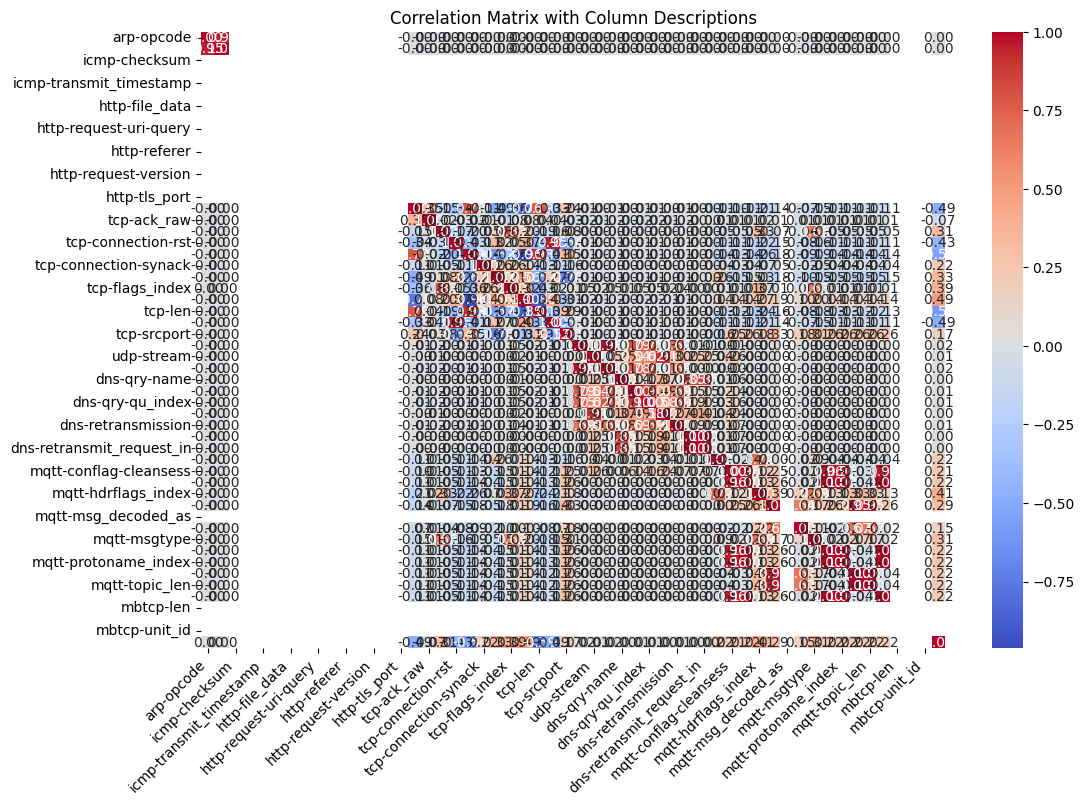


Wartości korelacji dla Attack_type_index:
arp-opcode                   0.000307
arp-hw-size                  0.000324
icmp-checksum                     NaN
icmp-seq_le                       NaN
icmp-transmit_timestamp           NaN
icmp-unused                       NaN
http-file_data                    NaN
http-content_length               NaN
http-request-uri-query            NaN
http-request-method               NaN
http-referer                      NaN
http-request-full_uri             NaN
http-request-version              NaN
http-response                     NaN
http-tls_port                     NaN
tcp-ack                     -0.486079
tcp-ack_raw                 -0.070468
tcp-connection-fin           0.313222
tcp-connection-rst          -0.431542
tcp-connection-syn          -0.542770
tcp-connection-synack        0.217456
tcp-dstport                  0.330640
tcp-flags_index              0.394890
tcp-flags-ack                0.493401
tcp-len                     -0.588599
tcp-seq

In [35]:
calculate_correlation_matrix(df_concat)

In [ ]:
parameters = [
    "arp-opcode",
    "arp-hw-size",
    "tcp-ack",
    "tcp-ack_raw",
    "tcp-connection-fin",
    "tcp-connection-rst",
    "tcp-connection-syn",
    "tcp-connection-synack",
    "tcp-dstport",
    "tcp-flags_index",
    "tcp-flags-ack",
    "tcp-len",
    "tcp-seq",
    "tcp-srcport",
    "udp-port",
    "udp-stream",
    "udp-time_delta",
    "dns-qry-name",
    "dns-qry-name-len_index",
    "dns-qry-qu_index",
    "dns-qry-type",
    "dns-retransmission",
    "dns-retransmit_request",
    "dns-retransmit_request_in",
    "mqtt-conack-flags_index",
    "mqtt-conflag-cleansess",
    "mqtt-conflags_index",
    "mqtt-hdrflags_index",
    "mqtt-len",
    "mqtt-msg_index",
    "mqtt-msgtype",
    "mqtt-proto_len",
    "mqtt-protoname_index",
    "mqtt-topic_index",
    "mqtt-topic_len",
    "mqtt-ver",
    "Attack_type_index"
]


In [41]:
#df = pandas_df.astype(str)

# Iteracja po nazwach kolumn
#for col in df.columns:
    # Sprawdzenie, czy kolumna zawiera określony ciąg znaków
#    if df[col].str.contains('Temperature_and_Humidity').any():
        # Jeśli tak, wyświetlenie nazwy kolumny
#        print(f"Określony ciąg znaków jest obecny w kolumnie: {col}")


# to jest nieistotne!!!!!!!!!!!!!!!!!

Określony ciąg znaków jest obecny w kolumnie: mqtt-topic
